In [1]:
# 学習データを無理やり増やす
# 画像の回転などのランダムな（ただし現実的な）変換を適用することで学習データの多様性を高める

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [3]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [4]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


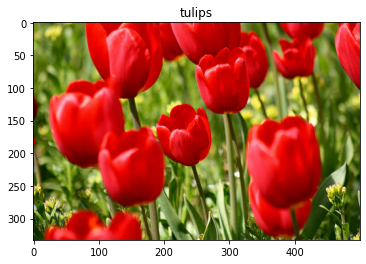

In [5]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [7]:
# 画像サイズの変更・再スケーリング

IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

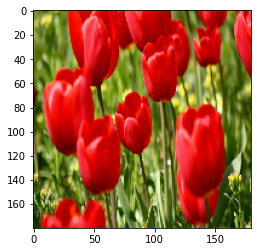

In [8]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [9]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


In [10]:
# 水平反転・回転
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
image = tf.expand_dims(image, 0)

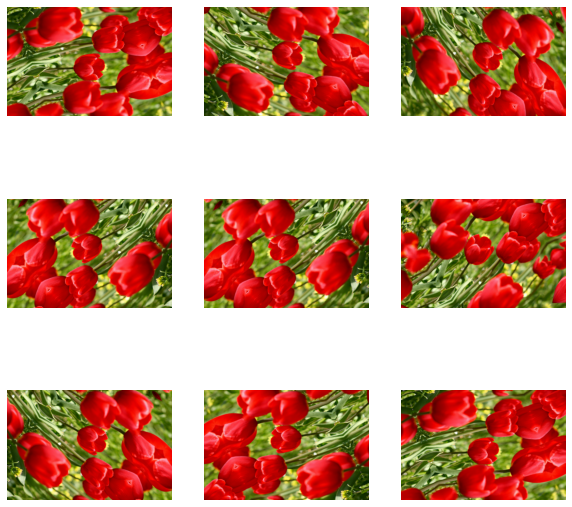

In [13]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

In [14]:
# 他にも，RandomConstrast, RandomCrop, RandomZoomなどが用意されている

In [15]:
# 前処理レイヤーをどのタイミングで使うか
# 1: モデルの一部に組み込む

model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
])

# 2: 前処理レイヤーをデータセットに適用する
# モデルをexportしたときに前処理部分が一緒に出てこないのでモデルを再利用するときに再実装するとか
# モデルに前処理部分をくっつけてexportするとかするとよい
aug_ds = train_ds.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
)

In [16]:
# 以下では前処理レイヤーをデータセットに対して適用する例を示す

In [17]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets
    ds = ds.batch(batch_size)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)

In [18]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [19]:
model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
epochs=5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 103s 1s/step - loss: 1.3512 - accuracy: 0.4254 - val_loss: 1.1289 - val_accuracy: 0.5722
Epoch 2/5
92/92 [==============================] - 98s 1s/step - loss: 1.0955 - accuracy: 0.5627 - val_loss: 1.0339 - val_accuracy: 0.5777
Epoch 3/5
92/92 [==============================] - 98s 1s/step - loss: 0.9849 - accuracy: 0.6124 - val_loss: 0.9428 - val_accuracy: 0.6349
Epoch 4/5
92/92 [==============================] - 98s 1s/step - loss: 0.9406 - accuracy: 0.6209 - val_loss: 0.9693 - val_accuracy: 0.6267
Epoch 5/5
92/92 [==============================] - 97s 1s/step - loss: 0.9129 - accuracy: 0.6451 - val_loss: 1.0161 - val_accuracy: 0.5913


In [22]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 4s 297ms/step - loss: 0.9412 - accuracy: 0.6185
Accuracy 0.6185286045074463


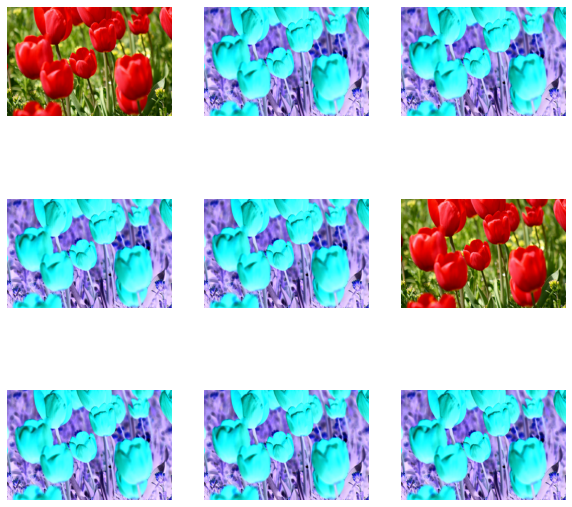

In [23]:
# データ拡張レイヤを自分で書くこともできる
# layers..Lambdaが便利：変換関数を書いて突っ込めばいい

def random_invert_img(x, p=0.5):
    if  tf.random.uniform([]) < p:
        x = (255-x)
    else:
        x
    return x

# random_invert layer
def random_invert(factor=0.5):
    return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = random_invert(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

In [24]:
# layers.Layerをサブクラス化して書くというのもあり
# layers.Layerのサブクラスとして定義してcallメソッドで変換関数を呼ぶように書く
class RandomInvert(layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor

    def call(self, x):
        return random_invert_img(x)

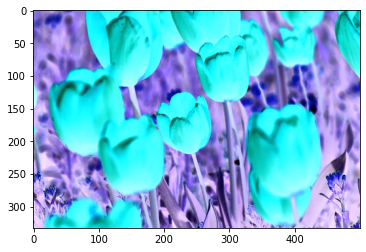

In [25]:
_ = plt.imshow(RandomInvert()(image)[0])

In [26]:
# 画像のdata augmentationに限ればtf.imageモジュールも便利

In [27]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

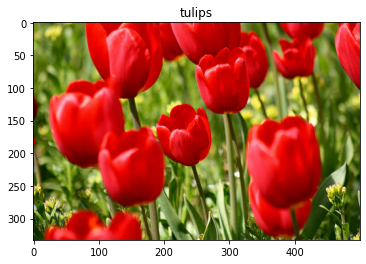

In [28]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [29]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

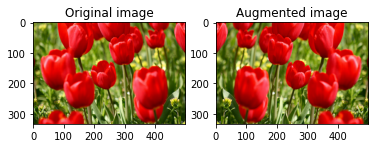

In [30]:
# tf.image.flip_left_right: 水平反転
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

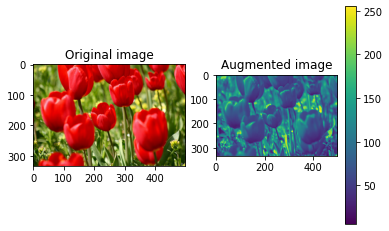

In [31]:
# tf.image.rgb_to_grayscale: 画像のグレースケール化
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

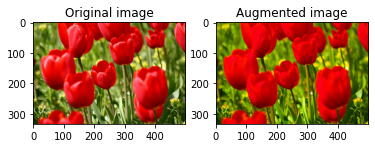

In [32]:
# tf.image.adjust_saturation: サチュレーションをいじる
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

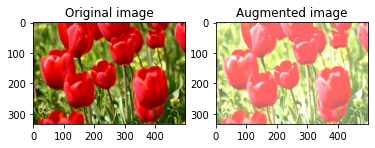

In [36]:
# tf.image.adjust_brightness: 明るさをいじる
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

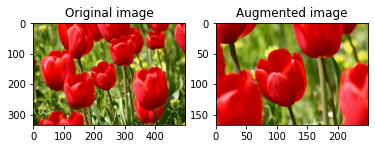

In [37]:
# tf.image.central_crop: 真ん中を切り抜く
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

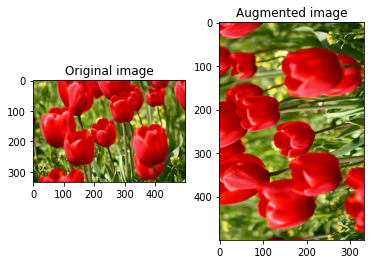

In [38]:
# tf.image.rot90: 90°回転
rotated = tf.image.rot90(image)
visualize(image, rotated)

In [39]:
# 他にもtf.image.hogehogeはたくさんある
# random/stateless_random
# stateless_randomを使うことでseedを指定すれば決定的なパイプラインを作れる．

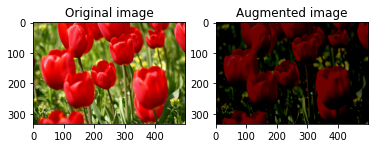

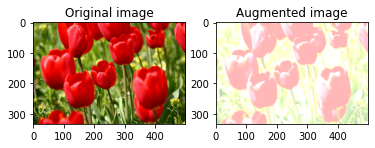

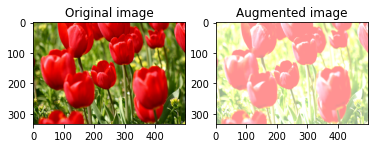

In [40]:
for i in range(3):
    seed = (i, 0)  # tuple of size (2,)
    stateless_random_brightness = tf.image.stateless_random_brightness(image, max_delta=0.95, seed=seed)
    visualize(image, stateless_random_brightness)

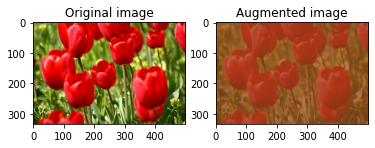

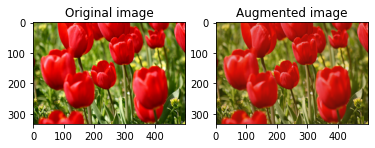

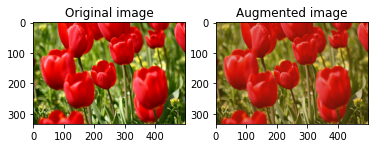

In [41]:
for i in range(3):
    seed = (i, 0)  # tuple of size (2,)
    stateless_random_contrast = tf.image.stateless_random_contrast(image, lower=0.1, upper=0.9, seed=seed)
    visualize(image, stateless_random_contrast)

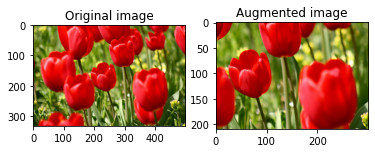

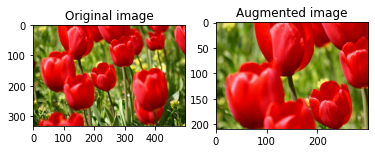

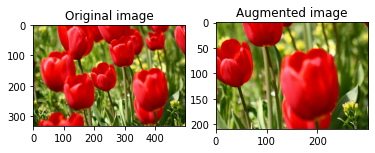

In [42]:
for i in range(3):
    seed = (i, 0)  # tuple of size (2,)
    stateless_random_crop = tf.image.stateless_random_crop(image, size=[210, 300, 3], seed=seed)
    visualize(image, stateless_random_crop)

In [43]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [44]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [45]:
def augment(image_label, seed):
    image, label = image_label
    image, label = resize_and_rescale(image, label)
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
    # Make a new seed
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    # Random crop back to the original size
    image = tf.image.stateless_random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
    # Random brightness
    image = tf.image.stateless_random_brightness(image, max_delta=0.5, seed=new_seed)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [46]:
# Create counter and zip together with train dataset
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

In [47]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [48]:
# Create a generator
rng = tf.random.Generator.from_seed(123, alg='philox')

# A wrapper function for updating seeds
def f(x, y):
    seed = rng.make_seeds(2)[0]
    image, label = augment((x, y), seed)
    return image, label

train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)